In [18]:

# ==========================================
# XGBoost 회귀 학습 전용 스크립트 (단일 학습 데이터 사용)
# 데이터 : C:\ESG_Project1\file\solar_data_file\남동발전량_지역매핑_시간행_기상병합.csv
# 타깃 :  "발전량(MWh)"  (연속형 회귀값)
# 출력 :  xgb_solar_pipeline.pkl  (원본 CSV와 같은 폴더에 저장)
# 기능 :  시간 파생 특성, 카테고리 원-핫, 결측치 처리, GPU 자동 감지, 훈련셋 지표 출력
# ==========================================

import os
import json
import warnings
import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from xgboost import XGBRegressor
from packaging import version

# ---------------------------
# 0. 사용자 설정
# ---------------------------
CSV_PATH = r"C:\ESG_Project1\file\solar_data_file\남동발전량_지역매핑_시간행_기상병합.csv"
TARGET_COL = "합산발전량(MWh)"
OUTPUT_NAME = "xgb_solar_pipeline.pkl"   # 원본 CSV 폴더에 저장
RANDOM_STATE = 42

# ---------------------------
# 1. 유틸 함수
# ---------------------------
def detect_datetime(df: pd.DataFrame):
    """
    여러 형태의 일자/시간 컬럼을 유연하게 처리하여 단일 datetime 컬럼을 생성합니다.
    지원 패턴:
      - '일시' 또는 'datetime' 단일 컬럼
      - '일자' + '시간' 분리 컬럼
      - 'date' + 'hour' 등 영문 대안
    반환: df, datetime_col_name
    """
    candidates_single = ["일시", "datetime", "timestamp", "DATE_TIME", "date_time"]
    for c in candidates_single:
        if c in df.columns:
            try:
                dt = pd.to_datetime(df[c], errors="coerce")
                if dt.notna().any():
                    df["__dt__"] = dt
                    return df, "__dt__"
            except Exception:
                pass

    date_candidates = ["일자", "date"]
    hour_candidates = ["시간", "hour", "HOUR"]
    date_col = next((c for c in date_candidates if c in df.columns), None)
    hour_col = next((c for c in hour_candidates if c in df.columns), None)
    if date_col is not None and hour_col is not None:
        try:
            # 시간 컬럼이 "1시", "01", 1 등 다양한 포맷일 수 있음
            h = df[hour_col].astype(str).str.extract(r"(\d{1,2})")[0].astype(float)
            h = h.clip(lower=0, upper=23).fillna(0).astype(int)
            dt = pd.to_datetime(df[date_col], errors="coerce") + pd.to_timedelta(h, unit="h")
            if dt.notna().any():
                df["__dt__"] = dt
                return df, "__dt__"
        except Exception:
            pass

    # 영흥/삼천포 등 시계열이 아닌 wide 형태를 피하기 위해 마지막 시도
    # 숫자형 시각 컬럼명이 '1시 발전량(MWh)' 같은 패턴일 경우는 이미 long 변환된 파일을 권장
    return df, None

def add_time_features(df: pd.DataFrame, dt_col: str):
    """dt_col 기준의 시간 파생 특성 생성"""
    if dt_col is None or dt_col not in df.columns:
        return df

    df["hour"] = df[dt_col].dt.hour
    df["dayofweek"] = df[dt_col].dt.dayofweek
    df["month"] = df[dt_col].dt.month
    df["is_weekend"] = (df["dayofweek"] >= 5).astype(int)

    # 주기형 인코딩
    df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24.0)
    df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24.0)
    df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12.0)
    df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12.0)

    return df

def choose_tree_method():
    """XGBoost GPU 사용 가능 시 gpu_hist, 아니면 hist"""
    try:
        # 대체로 GPU 빌드가 아니면 gpu_hist로 학습 시 에러 발생
        test_model = XGBRegressor(
            n_estimators=1,
            max_depth=1,
            tree_method="gpu_hist",
            predictor="gpu_predictor",
            verbosity=0
        )
        import numpy as np
        test_model.fit(np.array([[0,0]]), np.array([0.0]))
        return "gpu_hist", "gpu_predictor"
    except Exception:
        return "hist", "auto"

# ---------------------------
# 2. 데이터 로드
# ---------------------------
if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(f"CSV가 존재하지 않습니다: {CSV_PATH}")

df = pd.read_csv(CSV_PATH, encoding="utf-8", low_memory=False)
if TARGET_COL not in df.columns:
    # cp949 재시도
    try:
        df = pd.read_csv(CSV_PATH, encoding="cp949", low_memory=False)
    except Exception:
        pass

if TARGET_COL not in df.columns:
    raise ValueError(f"타깃 컬럼 '{TARGET_COL}' 이(가) CSV에 없습니다. 현재 컬럼: {list(df.columns)[:30]} ...")

# ---------------------------
# 3. 전처리 및 특성 엔지니어링
# ---------------------------
df, dt_col = detect_datetime(df)
df = add_time_features(df, dt_col)

# 타깃 결측 제거
df = df[df[TARGET_COL].notna()].copy()

# 피처와 타깃 분리
y = df[TARGET_COL].astype(float)
# 타깃 외 컬럼에서 의미 없는 고유 식별 컬럼 제거 후보
drop_like = {TARGET_COL}
# dt 원본은 제거하고 파생만 사용
if dt_col is not None:
    drop_like.add(dt_col)

X_raw = df.drop(columns=list(drop_like.intersection(df.columns)), errors="ignore")

# 숫자/범주형 컬럼 구분
numeric_cols = X_raw.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X_raw.select_dtypes(exclude=[np.number]).columns.tolist()

# ColumnTransformer 구성
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=True))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ],
    remainder="drop",
    sparse_threshold=0.3
)

tree_method, predictor = choose_tree_method()

model = XGBRegressor(
    n_estimators=1200,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=RANDOM_STATE,
    tree_method=tree_method,
    predictor=predictor,
    n_jobs=0,
)

pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", model)
])

# ---------------------------
# 4. 학습 (단일 학습셋만 사용, 검증/테스트 분리 없음)
# ---------------------------
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    pipe.fit(X_raw, y)

# ---------------------------
# 5. 훈련셋 지표 계산
# ---------------------------
y_pred = pipe.predict(X_raw)
mae = mean_absolute_error(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))  # ✅ 수정된 부분
r2 = r2_score(y, y_pred)

print("\n===== 훈련셋 성능 =====")
print(f"MAE : {mae:,.4f}")
print(f"RMSE: {rmse:,.4f}")
print(f"R^2 : {r2:,.4f}")

# ---------------------------
# 6. 아티팩트 저장
# ---------------------------
# 파이프라인 저장 경로는 CSV와 동일 폴더
out_dir = os.path.dirname(CSV_PATH)
os.makedirs(out_dir, exist_ok=True)

# joblib로 저장
try:
    import joblib
    joblib.dump(pipe, os.path.join(out_dir, OUTPUT_NAME))
    print(f"\n✅ 모델 파이프라인 저장 완료 → {os.path.join(out_dir, OUTPUT_NAME)}")
except Exception as e:
    print(f"\n⚠️ 파이프라인 저장 중 오류: {e}")

# 메타 정보와 지표 저장
meta = {
    "csv_path": CSV_PATH,
    "target": TARGET_COL,
    "datetime_used": bool(dt_col),
    "datetime_col": dt_col,
    "numeric_cols": numeric_cols,
    "categorical_cols": categorical_cols,
    "tree_method": tree_method,
    "predictor": predictor,
    "metrics_train": {"MAE": mae, "RMSE": rmse, "R2": r2}
}
with open(os.path.join(out_dir, "xgb_solar_meta.json"), "w", encoding="utf-8") as f:
    json.dump(meta, f, ensure_ascii=False, indent=2)

print(f"ℹ️ 메타 저장 완료 → {os.path.join(out_dir, 'xgb_solar_meta.json')}")

# 피처 중요도 간단 출력
try:
    # 전처리 후 피처명 복원
    ohe = pipe.named_steps["preprocess"].named_transformers_["cat"].named_steps["onehot"]
    cat_feature_names = []
    if hasattr(ohe, "get_feature_names_out"):
        cat_feature_names = ohe.get_feature_names_out(categorical_cols).tolist()

    feature_names = numeric_cols + cat_feature_names
    booster = pipe.named_steps["model"]
    importances = booster.feature_importances_
    # 상위 20개 출력
    order = np.argsort(importances)[::-1][:20]
    print("\n상위 20개 특성 중요도:")
    for idx in order:
        name = feature_names[idx] if idx < len(feature_names) else f"f{idx}"
        print(f"- {name}: {importances[idx]:.6f}")
except Exception as e:
    print(f"\n⚠️ 특성 중요도 출력 생략: {e}")



===== 훈련셋 성능 =====
MAE : 203.0834
RMSE: 671.8950
R^2 : 0.9548

✅ 모델 파이프라인 저장 완료 → C:\ESG_Project1\file\solar_data_file\xgb_solar_pipeline.pkl
ℹ️ 메타 저장 완료 → C:\ESG_Project1\file\solar_data_file\xgb_solar_meta.json

상위 20개 특성 중요도:
- hour_cos: 0.173749
- 지역_전라남도 고흥군: 0.061509
- 발전구분_고흥만 수상태양광: 0.026055
- 일조(hr): 0.023401
- hour_sin: 0.015999
- hour: 0.008414
- 일시_2024-05-27 13:00:00: 0.007175
- 일시_2024-05-28 13:00:00: 0.006869
- month_cos: 0.006040
- 일시_2024-05-14 13:00:00: 0.005365
- 일사(MJ/m2): 0.005014
- 일시_2024-09-05 13:00:00: 0.004134
- 일시_2024-03-10 12:00:00: 0.004052
- 일시_2024-04-07 11:00:00: 0.003905
- 지역_인천광역시 옹진군 영흥면: 0.003850
- 일시_2024-03-10 11:00:00: 0.003845
- 일시_2024-11-16 15:00:00: 0.003781
- month: 0.003761
- month_sin: 0.003537
- dayofweek: 0.003405


MAE : 203.08
RMSE: 671.89
R²  : 0.9548


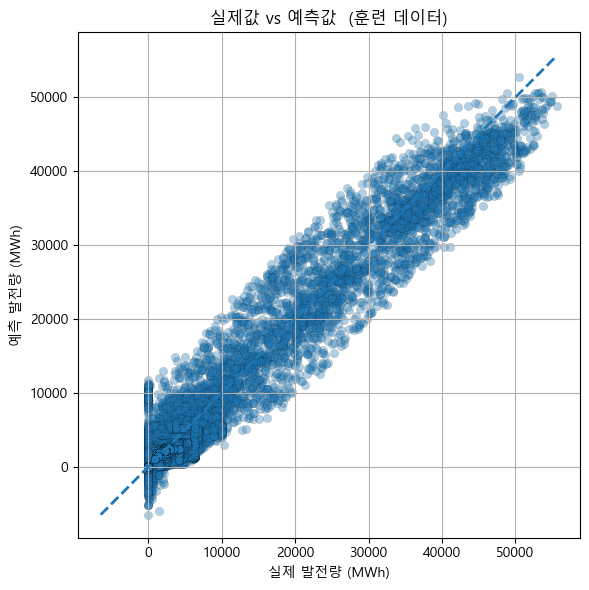

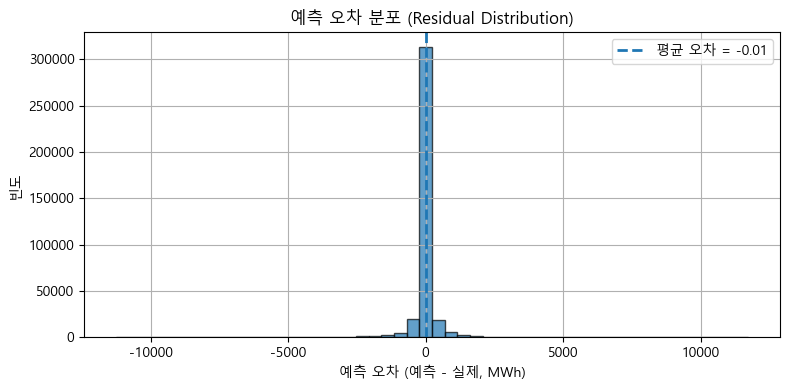

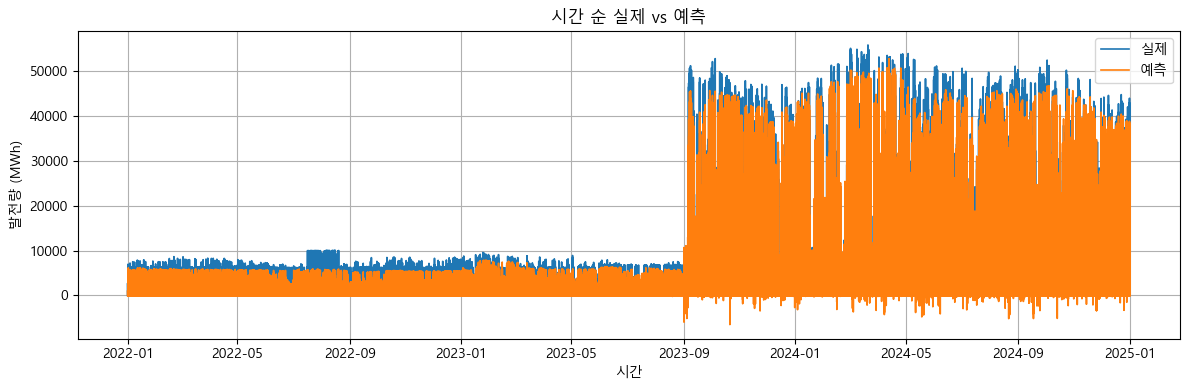

In [21]:

# ==========================================
# XGBoost 회귀 훈련 결과 시각화 (훈련 데이터로 예측)
# - 학습 시와 동일한 시간 파생 특성 생성
# - 한글 폰트 자동 설정
# - TARGET 컬럼 불일치 대비(메타 json 사용)
# ==========================================

import os
import json
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager, rcParams
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# -------------------------------
# 0) 경로/설정
# -------------------------------
CSV_PATH   = r"C:\ESG_Project1\file\solar_data_file\남동발전량_지역매핑_시간행_기상병합.csv"
MODEL_PATH = r"C:\ESG_Project1\file\solar_data_file\xgb_solar_pipeline.pkl"
META_PATH  = r"C:\ESG_Project1\file\solar_data_file\xgb_solar_meta.json"

# 사용자가 현재 그래프에서 쓰고자 하는 타깃 (데이터에 따라 조정)
USER_TARGET_COL = "합산발전량(MWh)"   # 필요 시 "발전량(MWh)" 로 변경

# -------------------------------
# A) 한글 폰트 자동 설정
# -------------------------------
def set_korean_font():
    candidates = [
        'Malgun Gothic',     # Windows
        'AppleGothic',       # macOS
        'NanumGothic',       # Linux
        'Noto Sans CJK KR',  # Noto
    ]
    installed = set(f.name for f in font_manager.fontManager.ttflist)
    for name in candidates:
        if name in installed:
            rcParams['font.family'] = name
            break
    else:
        # Windows 수동 경로 등록 시도
        win_path = r"C:\Windows\Fonts\malgun.ttf"
        if os.path.exists(win_path):
            prop = font_manager.FontProperties(fname=win_path)
            font_manager.fontManager.addfont(win_path)
            rcParams['font.family'] = prop.get_name()

    rcParams['axes.unicode_minus'] = False

set_korean_font()

# -------------------------------
# B) 시간 컬럼 탐지/파생 함수 (훈련과 동일)
# -------------------------------
def detect_datetime(df: pd.DataFrame):
    candidates_single = ["일시", "datetime", "timestamp", "DATE_TIME", "date_time"]
    for c in candidates_single:
        if c in df.columns:
            try:
                dt = pd.to_datetime(df[c], errors="coerce")
                if dt.notna().any():
                    df["__dt__"] = dt
                    return df, "__dt__"
            except Exception:
                pass

    date_candidates = ["일자", "date"]
    hour_candidates = ["시간", "hour", "HOUR"]
    date_col = next((c for c in date_candidates if c in df.columns), None)
    hour_col = next((c for c in hour_candidates if c in df.columns), None)
    if date_col is not None and hour_col is not None:
        try:
            h = df[hour_col].astype(str).str.extract(r"(\d{1,2})")[0].astype(float)
            h = h.clip(lower=0, upper=23).fillna(0).astype(int)
            dt = pd.to_datetime(df[date_col], errors="coerce") + pd.to_timedelta(h, unit="h")
            if dt.notna().any():
                df["__dt__"] = dt
                return df, "__dt__"
        except Exception:
            pass

    return df, None

def add_time_features(df: pd.DataFrame, dt_col: str):
    if dt_col is None or dt_col not in df.columns:
        return df
    df["hour"] = df[dt_col].dt.hour
    df["dayofweek"] = df[dt_col].dt.dayofweek
    df["month"] = df[dt_col].dt.month
    df["is_weekend"] = (df["dayofweek"] >= 5).astype(int)
    df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24.0)
    df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24.0)
    df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12.0)
    df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12.0)
    return df

# -------------------------------
# 1) 데이터 로드
# -------------------------------
encodings = ["utf-8", "cp949"]
last_err = None
for enc in encodings:
    try:
        df = pd.read_csv(CSV_PATH, encoding=enc, low_memory=False)
        break
    except Exception as e:
        last_err = e
        df = None
if df is None:
    raise last_err

# -------------------------------
# 2) 타깃 컬럼 결정 (메타 파일 우선)
# -------------------------------
train_target = None
if os.path.exists(META_PATH):
    try:
        with open(META_PATH, "r", encoding="utf-8") as f:
            meta = json.load(f)
        train_target = meta.get("target", None)
    except Exception:
        pass

# 사용자가 지정한 타깃 우선, 없으면 학습 타깃 사용
target_candidates = []
if USER_TARGET_COL and USER_TARGET_COL in df.columns:
    target_candidates.append(USER_TARGET_COL)
if train_target and train_target in df.columns and train_target not in target_candidates:
    target_candidates.append(train_target)

if not target_candidates:
    raise ValueError(f"데이터에서 타깃 컬럼을 찾지 못했습니다. 후보: USER_TARGET_COL='{USER_TARGET_COL}', meta.target='{train_target}'")

TARGET_COL = target_candidates[0]

# 결측 제거
df = df[df[TARGET_COL].notna()].copy()
y_true = df[TARGET_COL].astype(float)

# -------------------------------
# 3) 학습과 동일하게 시간 파생 생성
# -------------------------------
df, dt_col = detect_datetime(df)
df = add_time_features(df, dt_col)

# -------------------------------
# 4) 모델 로드 및 예측
# -------------------------------
pipe = joblib.load(MODEL_PATH)

# 누수 방지를 위해: USER_TARGET_COL과 train_target이 모두 있으면 둘 다 제거
cols_to_drop = set()
if USER_TARGET_COL in df.columns:
    cols_to_drop.add(USER_TARGET_COL)
if train_target and train_target in df.columns:
    cols_to_drop.add(train_target)

X = df.drop(columns=list(cols_to_drop), errors="ignore")
y_pred = pipe.predict(X)

# -------------------------------
# 5) 지표 출력
# -------------------------------
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2  = r2_score(y_true, y_pred)

print(f"MAE : {mae:,.2f}")
print(f"RMSE: {rmse:,.2f}")
print(f"R²  : {r2:,.4f}")

# -------------------------------
# 6) 시각화
# -------------------------------

# 6-1) 실제 vs 예측 산점도
plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, alpha=0.35, edgecolor='k', linewidth=0.2)
min_v = float(min(y_true.min(), y_pred.min()))
max_v = float(max(y_true.max(), y_pred.max()))
plt.plot([min_v, max_v], [min_v, max_v], linestyle='--', linewidth=2)
plt.xlabel("실제 발전량 (MWh)")
plt.ylabel("예측 발전량 (MWh)")
plt.title("실제값 vs 예측값  (훈련 데이터)")
plt.grid(True)
plt.tight_layout()
plt.show()

# 6-2) 예측 오차 분포
errors = y_pred - y_true
plt.figure(figsize=(8,4))
plt.hist(errors, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(errors.mean(), linestyle='dashed', linewidth=2, label=f"평균 오차 = {errors.mean():.2f}")
plt.xlabel("예측 오차 (예측 - 실제, MWh)")
plt.ylabel("빈도")
plt.title("예측 오차 분포 (Residual Distribution)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 6-3) 시계열 추세 (datetime 있는 경우)
if dt_col is not None:
    order = np.argsort(df[dt_col].values)
    plt.figure(figsize=(12,4))
    plt.plot(df[dt_col].values[order], y_true.values[order], label="실제", linewidth=1.2)
    plt.plot(df[dt_col].values[order], np.array(y_pred)[order], label="예측", linewidth=1.2)
    plt.xlabel("시간")
    plt.ylabel("발전량 (MWh)")
    plt.title("시간 순 실제 vs 예측")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



==== 이상치 탐지 결과 ====
방법: sigma3 / 규칙: abs_err > mean+3σ (thr=2124.489)
총 샘플: 376,368
이상치 개수: 6,883
저장: 
 - 전체: C:\ESG_Project1\file\solar_data_file\outliers_labeled.csv
 - 이상치만: C:\ESG_Project1\file\solar_data_file\outliers_only.csv


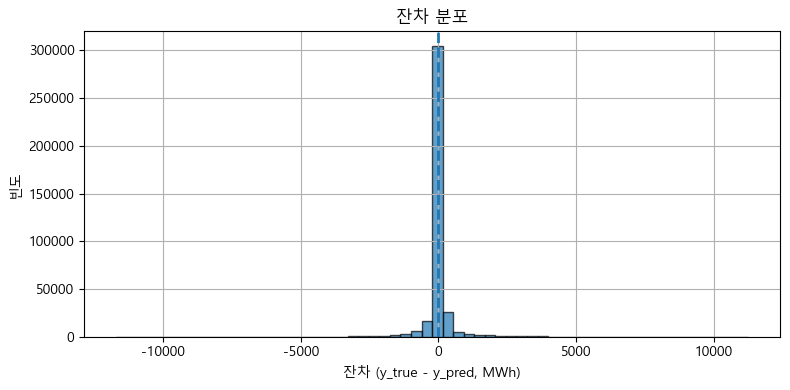

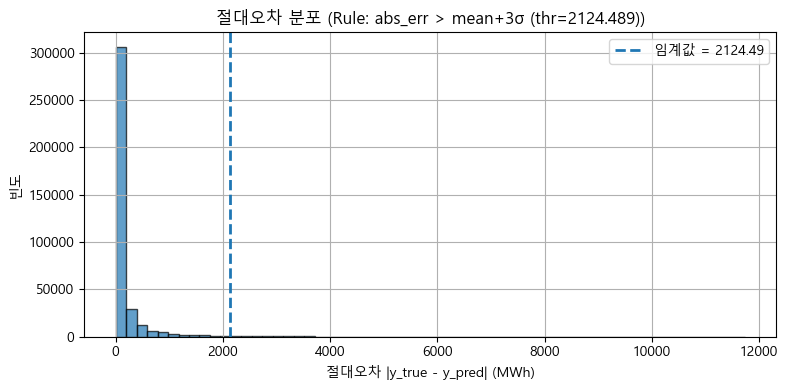

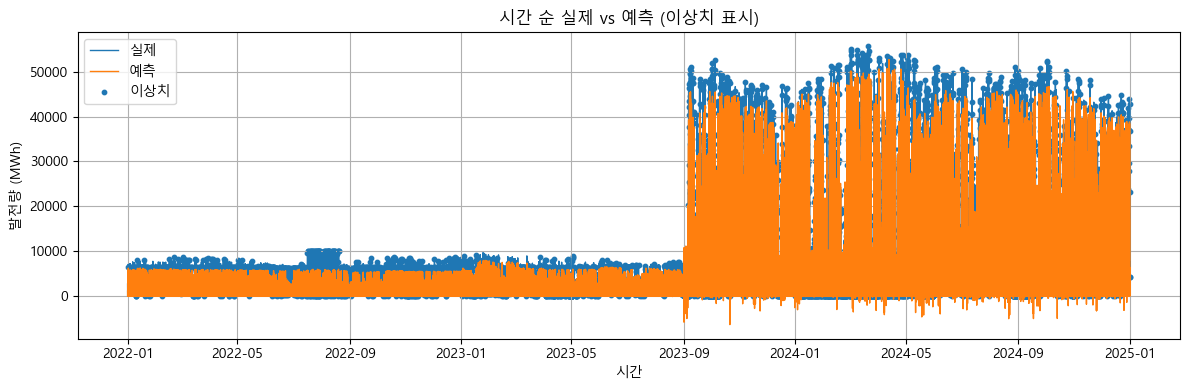

In [23]:

# ==========================================
# 회귀 예측 오차 기반 이상치 탐지 스크립트
# - 학습된 XGBoost 파이프라인 사용
# - 시간 파생 특성 자동 생성 (학습과 동일)
# - 3가지 기준 지원: 'sigma3' | 'percentile' | 'iqr'
# - 결과 CSV 2종 저장: 전체+플래그 / 이상치만
# - 간단한 그래프 3종 출력 (matplotlib)
# ==========================================

import os
import json
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager, rcParams

# -------------------------------
# 0) 경로/설정
# -------------------------------
CSV_PATH   = r"C:\ESG_Project1\file\solar_data_file\남동발전량_지역매핑_시간행_기상병합.csv"
MODEL_PATH = r"C:\ESG_Project1\file\solar_data_file\xgb_solar_pipeline.pkl"
META_PATH  = r"C:\ESG_Project1\file\solar_data_file\xgb_solar_meta.json"

# 사용자 타깃 컬럼명 (데이터에 맞게 변경 가능)
USER_TARGET_COL = "합산발전량(MWh)"   # 또는 "합산발전량(MWh)"

# 이상치 판정 방법과 파라미터
METHOD = "sigma3"           # 'sigma3' | 'percentile' | 'iqr'
PERC   = 99                 # METHOD='percentile'일 때 사용 (상위 PERC%를 이상치로)
IQR_K  = 1.5                # METHOD='iqr'일 때 사용 (Q3 + k*IQR)

# 결과 저장 파일명
OUT_ALL  = r"C:\ESG_Project1\file\solar_data_file\outliers_labeled.csv"
OUT_ONLY = r"C:\ESG_Project1\file\solar_data_file\outliers_only.csv"

# -------------------------------
# A) 한글 폰트 자동 설정
# -------------------------------
def set_korean_font():
    candidates = ['Malgun Gothic', 'AppleGothic', 'NanumGothic', 'Noto Sans CJK KR']
    installed = set(f.name for f in font_manager.fontManager.ttflist)
    for name in candidates:
        if name in installed:
            rcParams['font.family'] = name
            break
    else:
        win_path = r"C:\Windows\Fonts\malgun.ttf"
        if os.path.exists(win_path):
            prop = font_manager.FontProperties(fname=win_path)
            font_manager.fontManager.addfont(win_path)
            rcParams['font.family'] = prop.get_name()
    rcParams['axes.unicode_minus'] = False

set_korean_font()

# -------------------------------
# B) 시간 컬럼 탐지/파생 특성
# -------------------------------
def detect_datetime(df: pd.DataFrame):
    candidates_single = ["일시", "datetime", "timestamp", "DATE_TIME", "date_time"]
    for c in candidates_single:
        if c in df.columns:
            try:
                dt = pd.to_datetime(df[c], errors="coerce")
                if dt.notna().any():
                    df["__dt__"] = dt
                    return df, "__dt__"
            except Exception:
                pass

    date_candidates = ["일자", "date"]
    hour_candidates = ["시간", "hour", "HOUR"]
    date_col = next((c for c in date_candidates if c in df.columns), None)
    hour_col = next((c for c in hour_candidates if c in df.columns), None)
    if date_col is not None and hour_col is not None:
        try:
            h = df[hour_col].astype(str).str.extract(r"(\d{1,2})")[0].astype(float)
            h = h.clip(lower=0, upper=23).fillna(0).astype(int)
            dt = pd.to_datetime(df[date_col], errors="coerce") + pd.to_timedelta(h, unit="h")
            if dt.notna().any():
                df["__dt__"] = dt
                return df, "__dt__"
        except Exception:
            pass
    return df, None

def add_time_features(df: pd.DataFrame, dt_col: str):
    if dt_col is None or dt_col not in df.columns:
        return df
    df["hour"] = df[dt_col].dt.hour
    df["dayofweek"] = df[dt_col].dt.dayofweek
    df["month"] = df[dt_col].dt.month
    df["is_weekend"] = (df["dayofweek"] >= 5).astype(int)
    df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24.0)
    df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24.0)
    df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12.0)
    df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12.0)
    return df

# -------------------------------
# 1) 데이터 로드
# -------------------------------
encodings = ["utf-8", "cp949"]
last_err = None
for enc in encodings:
    try:
        df = pd.read_csv(CSV_PATH, encoding=enc, low_memory=False)
        break
    except Exception as e:
        last_err = e
        df = None
if df is None:
    raise last_err

# -------------------------------
# 2) 타깃 결정 (메타 > 사용자)
# -------------------------------
train_target = None
if os.path.exists(META_PATH):
    try:
        with open(META_PATH, "r", encoding="utf-8") as f:
            meta = json.load(f)
        train_target = meta.get("target", None)
    except Exception:
        pass

target_candidates = []
if USER_TARGET_COL and USER_TARGET_COL in df.columns:
    target_candidates.append(USER_TARGET_COL)
if train_target and train_target in df.columns and train_target not in target_candidates:
    target_candidates.append(train_target)

if not target_candidates:
    raise ValueError(f"타깃 컬럼을 찾지 못했습니다. USER_TARGET_COL='{USER_TARGET_COL}', meta.target='{train_target}'")
TARGET_COL = target_candidates[0]

# -------------------------------
# 3) 전처리 및 예측
# -------------------------------
df = df[df[TARGET_COL].notna()].copy()
y_true = df[TARGET_COL].astype(float)

df, dt_col = detect_datetime(df)
df = add_time_features(df, dt_col)

pipe = joblib.load(MODEL_PATH)

# 타깃 누수 방지: 두 타깃 컬럼 모두 제거
cols_to_drop = set()
if USER_TARGET_COL in df.columns: cols_to_drop.add(USER_TARGET_COL)
if train_target and train_target in df.columns: cols_to_drop.add(train_target)

X = df.drop(columns=list(cols_to_drop), errors="ignore")
y_pred = pipe.predict(X)

# -------------------------------
# 4) 이상치 지표 계산
# -------------------------------
residual = y_true - y_pred       # (+)면 과소예측, (-)면 과대예측
abs_err  = np.abs(residual)

# 기준값 계산
if METHOD == "sigma3":
    thr = abs_err.mean() + 3 * abs_err.std(ddof=0)
    flag = abs_err > thr
    rule = f"abs_err > mean+3σ (thr={thr:.3f})"

elif METHOD == "percentile":
    thr = np.percentile(abs_err, PERC)
    flag = abs_err >= thr
    rule = f"abs_err >= {PERC}th perc (thr={thr:.3f})"

elif METHOD == "iqr":
    q1, q3 = np.percentile(abs_err, [25, 75])
    iqr = q3 - q1
    thr = q3 + IQR_K * iqr
    flag = abs_err > thr
    rule = f"abs_err > Q3+{IQR_K}*IQR (thr={thr:.3f})"
else:
    raise ValueError("METHOD must be one of: 'sigma3' | 'percentile' | 'iqr'")

# 결과 컬럼 추가
df_out = df.copy()
df_out["_y_true"] = y_true.values
df_out["_y_pred"] = y_pred
df_out["_residual"] = residual
df_out["_abs_err"] = abs_err
df_out["_is_outlier"] = flag.astype(int)
df_out["_rule"] = rule

# -------------------------------
# 5) 저장
# -------------------------------
df_out.to_csv(OUT_ALL, index=False, encoding="utf-8-sig")
df_out[df_out["_is_outlier"] == 1].to_csv(OUT_ONLY, index=False, encoding="utf-8-sig")

print("==== 이상치 탐지 결과 ====")
print(f"방법: {METHOD} / 규칙: {rule}")
print(f"총 샘플: {len(df_out):,d}")
print(f"이상치 개수: {int(df_out['_is_outlier'].sum()):,d}")
print(f"저장: \n - 전체: {OUT_ALL}\n - 이상치만: {OUT_ONLY}")

# -------------------------------
# 6) 그래프
# -------------------------------

# 6-1) 잔차 분포
plt.figure(figsize=(8,4))
plt.hist(residual, bins=60, edgecolor='black', alpha=0.7)
plt.axvline(0, linestyle='dashed', linewidth=2)
plt.xlabel("잔차 (y_true - y_pred, MWh)")
plt.ylabel("빈도")
plt.title("잔차 분포")
plt.grid(True)
plt.tight_layout()
plt.show()

# 6-2) 절대오차 분포 + 임계값
plt.figure(figsize=(8,4))
plt.hist(abs_err, bins=60, edgecolor='black', alpha=0.7)
plt.axvline(thr, linestyle='dashed', linewidth=2, label=f"임계값 = {thr:.2f}")
plt.xlabel("절대오차 |y_true - y_pred| (MWh)")
plt.ylabel("빈도")
plt.title(f"절대오차 분포 (Rule: {rule})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 6-3) 시간축에서 이상치 마킹 (datetime 있으면)
if dt_col is not None:
    order = np.argsort(df[dt_col].values)
    t = df[dt_col].values[order]
    plt.figure(figsize=(12,4))
    plt.plot(t, y_true.values[order], label="실제", linewidth=1.0)
    plt.plot(t, y_pred[order], label="예측", linewidth=1.0)
    # 이상치 위치 점만 표시
    idx = np.where(flag.values[order])[0]
    if len(idx) > 0:
        plt.scatter(t[idx], y_true.values[order][idx], s=10, label="이상치")
    plt.xlabel("시간")
    plt.ylabel("발전량 (MWh)")
    plt.title("시간 순 실제 vs 예측 (이상치 표시)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
